In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime

ModuleNotFoundError: No module named 'pandas'

In [1]:
# Step 1: Data Loading and Preprocessing
# data = pd.read_csv('company4.csv')
data = pd.read_csv('company4.csv')
data.head()


NameError: name 'pd' is not defined

In [ ]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.columns

Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [ ]:
# Categorize 'Store' and 'Dept' columns as categorical
data['Store'] = data['Store'].astype('category')
data['Dept'] = data['Dept'].astype('category')

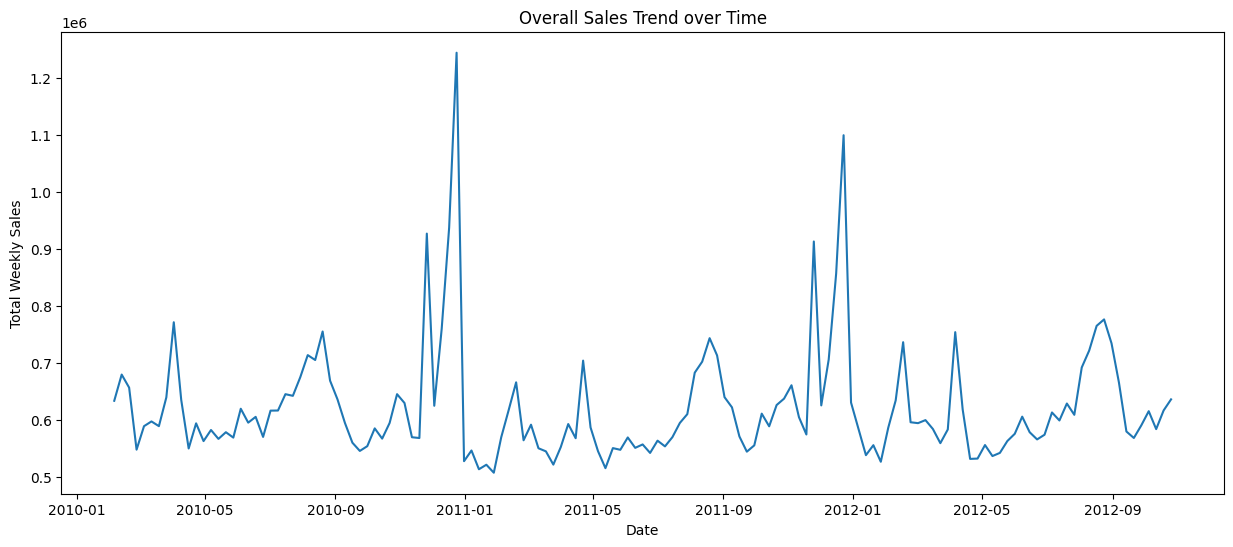

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
# TM1: Overall sales trend over time
overall_sales_trend = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(overall_sales_trend['Date'], overall_sales_trend['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Overall Sales Trend over Time')
plt.show()

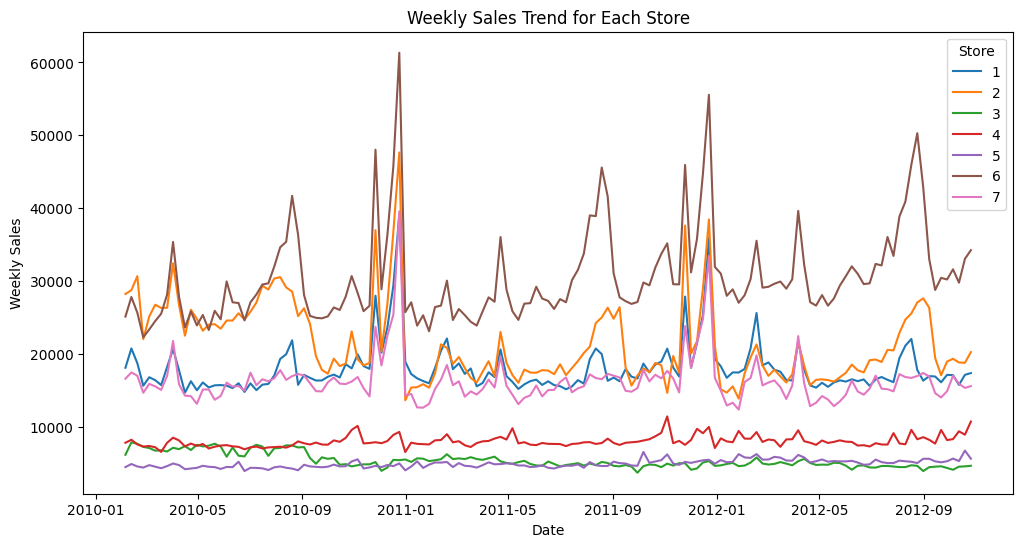

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=data, hue='Store', errorbar=None)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Trend for Each Store')
plt.show()

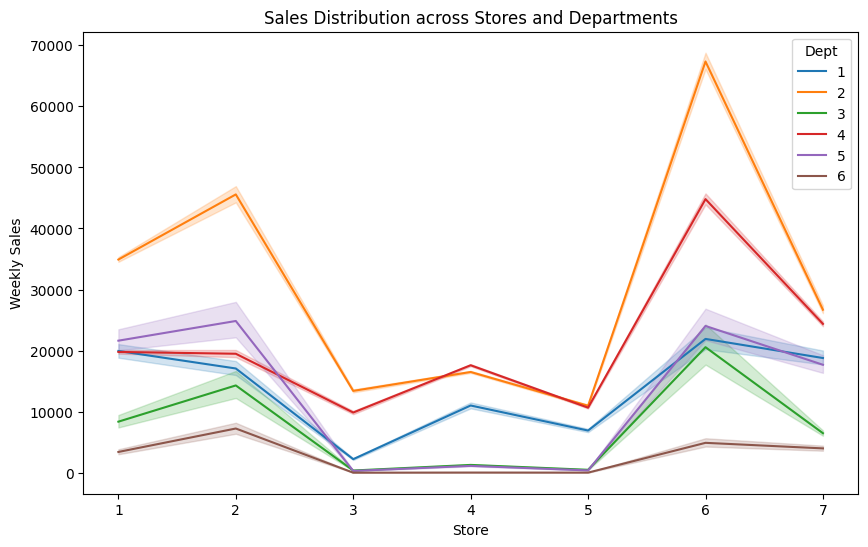

In [ ]:
# TM3: Sales distribution across stores and departments
plt.figure(figsize=(10, 6))
sns.lineplot(x='Store', y='Weekly_Sales', data=data, hue='Dept')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.title('Sales Distribution across Stores and Departments')
plt.show()

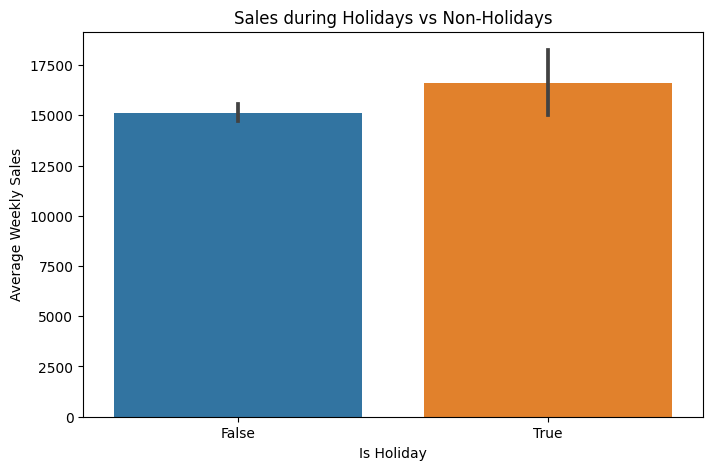

In [ ]:
# TM4: Sales during holidays and non-holiday periods
plt.figure(figsize=(8, 5))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.title('Sales during Holidays vs Non-Holidays')
plt.show()

In [ ]:
data['Weekly_Sales'].dropna()

0       20347.48
1       36644.15
2       27545.97
3       15768.00
4       17335.02
          ...   
5834     4473.46
5835     4279.00
5836     3088.78
5837     2863.32
5838     1913.35
Name: Weekly_Sales, Length: 5839, dtype: float64

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
#read data
data = pd.read_csv('company4.csv', parse_dates=[0], index_col=0, date_parser=parser)
#infer the frequency of the data

data = data[~data.index.duplicated(keep='first')]
data = data.asfreq(pd.infer_freq(data.index))

#transform
start_date = datetime(2010,2,5)
end_date = datetime(2012,10,26)
data = data[start_date:end_date]

In [4]:
data.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,1,1,19742.81,False
2012-10-05,1,1,19513.06,False
2012-10-12,1,1,20040.76,False
2012-10-19,1,1,23496.65,False
2012-10-26,1,1,25051.36,False


Text(0, 0.5, 'Sales')

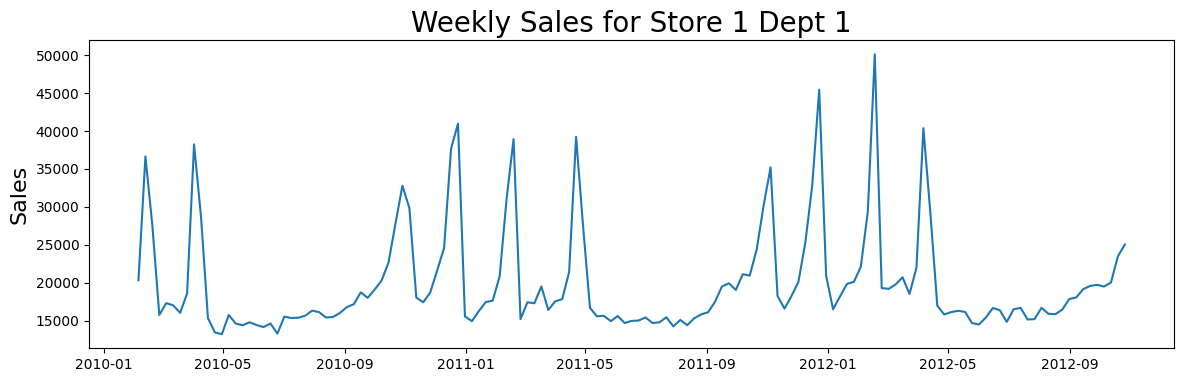

In [6]:
#plot
plt.figure(figsize=(14,4))
plt.plot(data['Weekly_Sales'])
plt.title('Weekly Sales for Store 1 Dept 1', fontsize=20)
plt.ylabel('Sales', fontsize=16)

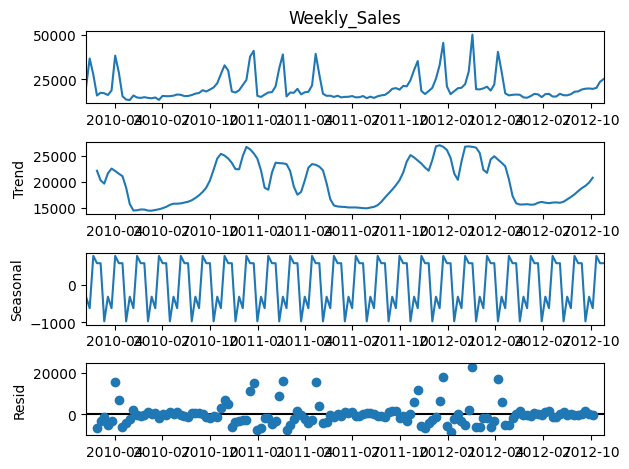

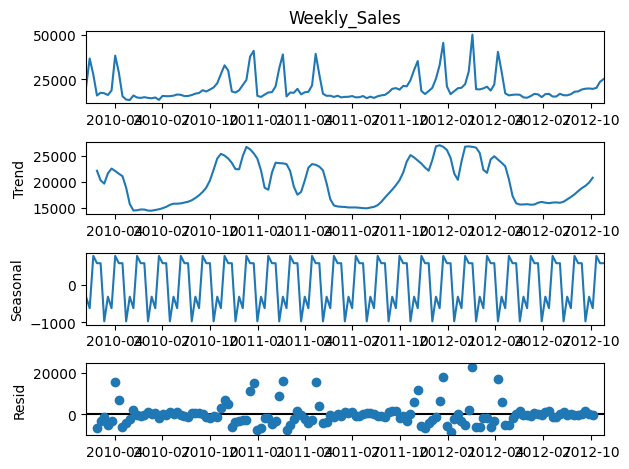

In [5]:
decomposition = seasonal_decompose(data['Weekly_Sales'], model='additive', period=6)
decomposition.plot()



In [8]:
data['Weekly_Sales'].dropna()

Date
2010-02-05    20347.48
2010-02-12    36644.15
2010-02-19    27545.97
2010-02-26    15768.00
2010-03-05    17335.02
                ...   
2012-09-28    19742.81
2012-10-05    19513.06
2012-10-12    20040.76
2012-10-19    23496.65
2012-10-26    25051.36
Freq: W-FRI, Name: Weekly_Sales, Length: 143, dtype: float64

In [6]:
# To check data is stationary or not
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(data['Weekly_Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -2.0604829367394815
p-value: 0.26069847723846207


In [7]:
#As p value is not less than 0.05 we have to use difference method to make data stationary
data['diff_Weekly_Sales'] = data['Weekly_Sales'] - data['Weekly_Sales'].shift(1)

data.head()



,Store,Dept,Weekly_Sales,IsHoliday,diff_Weekly_Sales
Date,,,,,
2010-02-05,1,1,20347.48,False,NaN
2010-02-12,1,1,36644.15,True,16296.67
2010-02-19,1,1,27545.97,False,-9098.18
2010-02-26,1,1,15768.00,False,-11777.97
2010-03-05,1,1,17335.02,False,1567.02


In [8]:
#making data stationary by making p value is very less
ad_fuller_result = adfuller(data['diff_Weekly_Sales'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.060167275645833
p-value: 4.5859590572785e-15


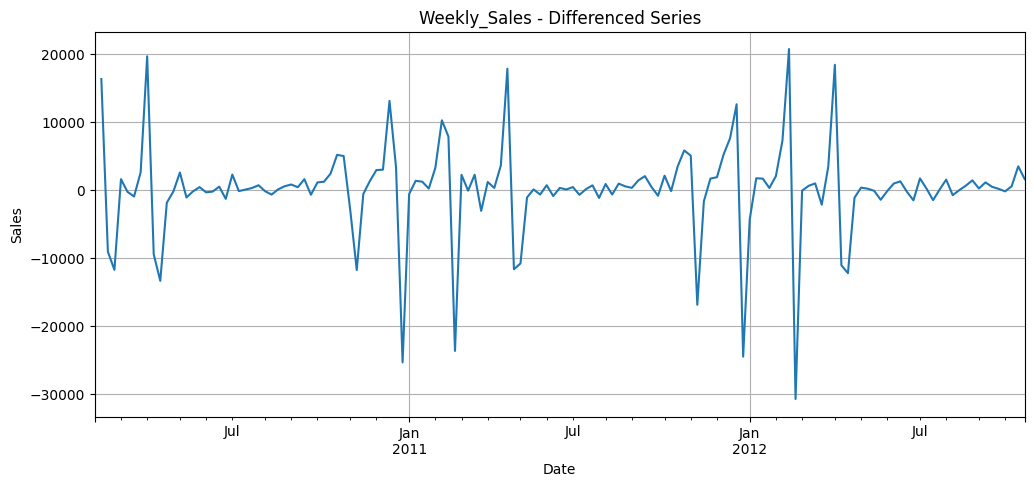

In [9]:
plt.figure(figsize=[12, 5]); # Set dimensions for figure
data['diff_Weekly_Sales'].plot()
plt.title('Weekly_Sales - Differenced Series')
plt.ylabel('Sales')
plt.grid(True)

In [ ]:
#We can see the seasonality in the weekly sales of store 1 dept 1 in the month of July and next July

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


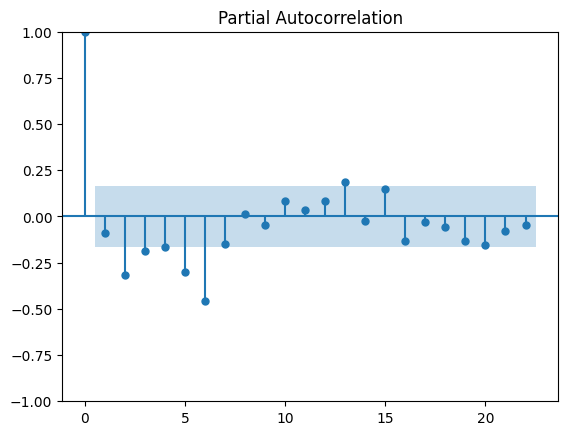

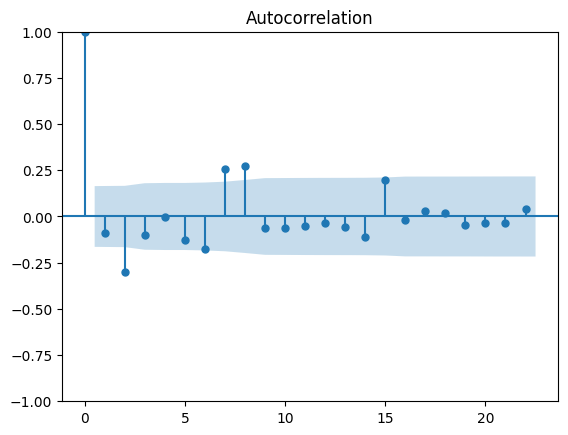

In [10]:
#Applying sarima models to the stationary data
plot_pacf(data['diff_Weekly_Sales'].iloc[1:]);
plot_acf(data['diff_Weekly_Sales'].iloc[1:]);

In [11]:
# Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit p(AR)= 2,5,6
# Using the ACF here we can see that 3 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2
# d=1 as we have taken difference 1 time
# So order(p,d,q)
# for P,D,Q and s, P=2, D=1, Q=2 and s=52
result = SARIMAX(data['diff_Weekly_Sales'],order=(2,1,2), seasonal_order=(2,1,2,52))
result = result.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


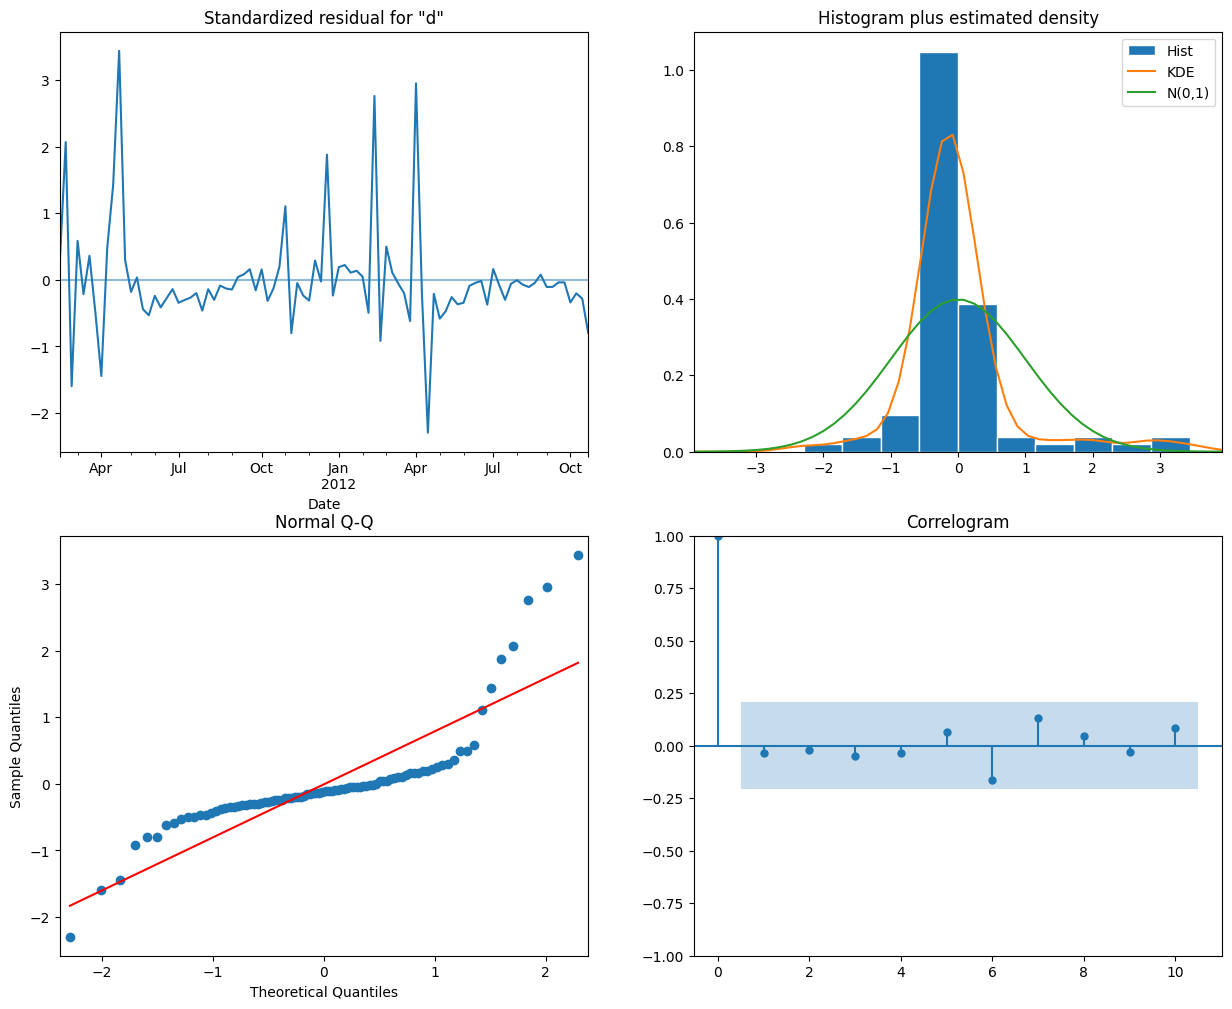

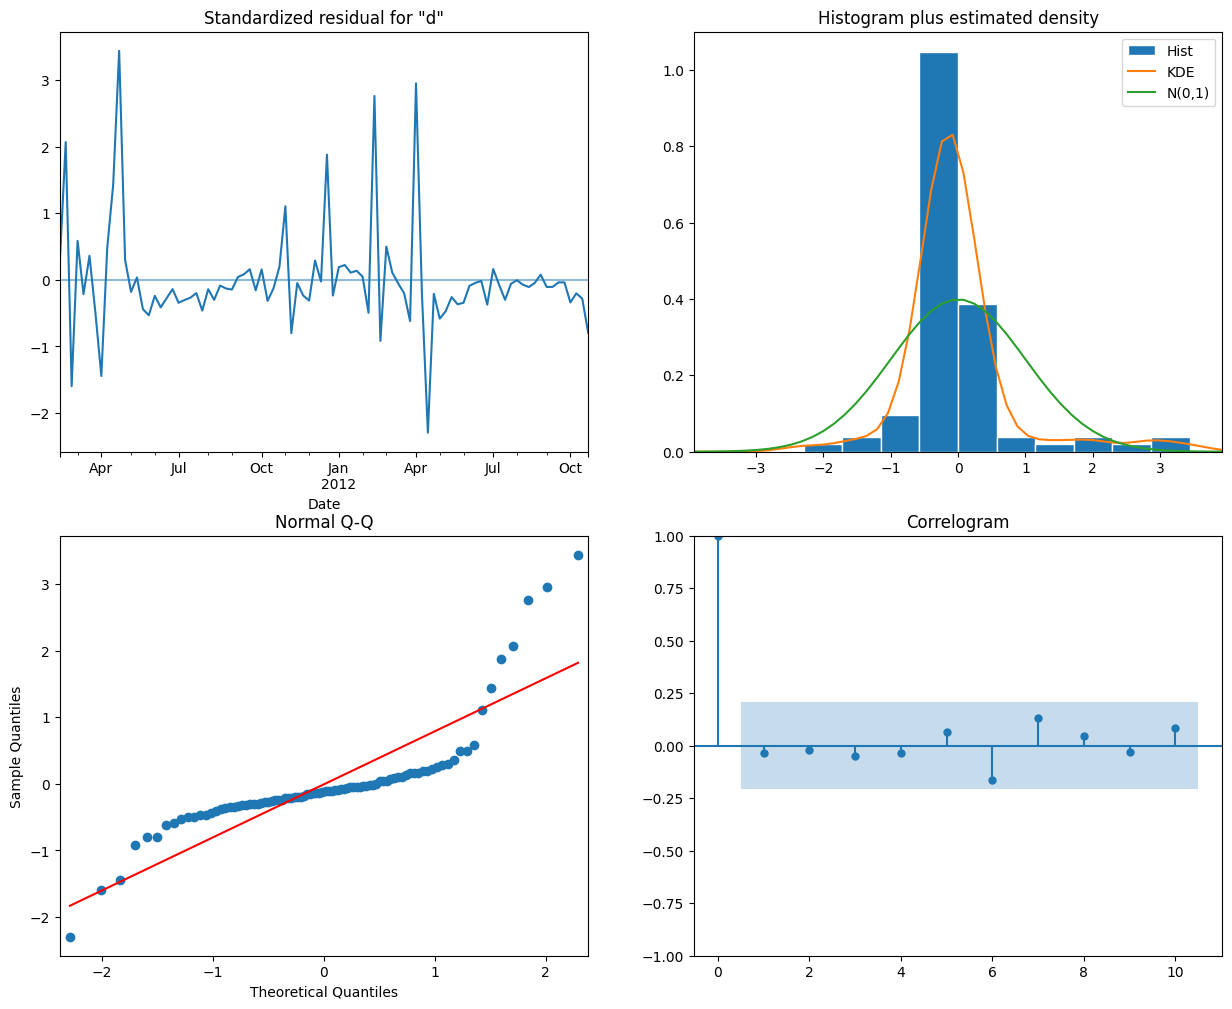

In [12]:

#Diagnosing the model residuals
result.plot_diagnostics(figsize=(15,12))
# From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality.
# The correlogram on the bottom right suggests that there is no autocorrelation in the residuals and so they are effectively white noise.
# Therefore, these residuals are uncorrelated and the mean is close to zero.

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  diff_Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 52)   Log Likelihood                -900.778
Date:                            Mon, 24 Jul 2023   AIC                           1819.556
Time:                                    16:26:38   BIC                           1842.054
Sample:                                02-05-2010   HQIC                          1828.628
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3908      0.185      2.108      0.035       0.027       0.754
ar.L2         -0.2748      0.262     -1.049      0.294      -0.788       0.239
ma.L1         -1.9341      0.828     -2.337      0.019      -3.556      -0.312
ma.L2          0.9401      0.793      1.185      0.236      -0.615       2.495
ar.S.L52      -0.7697   2651.147     -0.000      1.000   -5196.923    5195.384
ar.S.L104     -0.0985    368.606     -0.000      1.000    -722.553     722.356
ma.S.L52       0.3599   2656.736      0.000      1.000   -5206.748    5207.467
ma.S.L104     -0.1722    703.855     -0.000      1.000   -1379.702    1379.358
sigma2      3.822e+07      0.003   1.14e+10      0.000    3.82e+07    3.82e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               226.28
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             1.90
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+28. Standard errors may be unstable.
"""

<ipython-input-14-6e393d99ccf9>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast = data['sarima_model'].append(forecast)


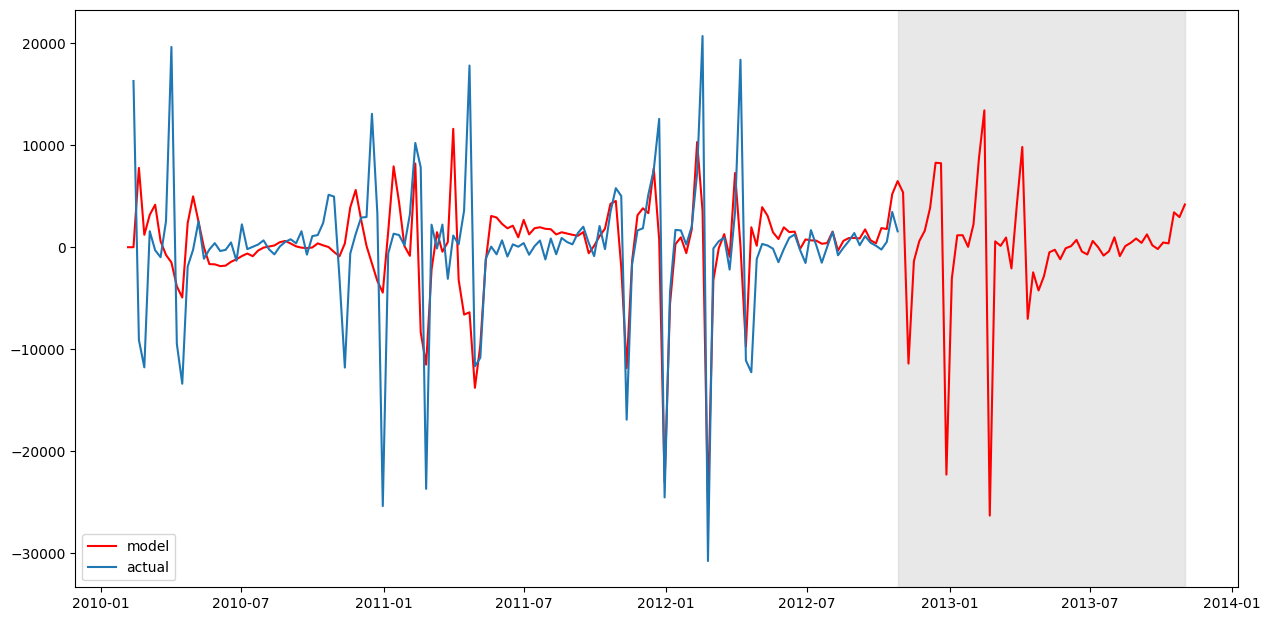

In [14]:
data['sarima_model'] = result.fittedvalues

forecast = result.predict(start=data.shape[0], end=data.shape[0] + 52)
forecast = data['sarima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['diff_Weekly_Sales'], label='actual')
plt.legend()
plt.show()

In [15]:
data['sarima_model'].head()

Date
2010-02-05       0.000000
2010-02-12       0.000000
2010-02-19    7778.954276
2010-02-26    1214.617602
2010-03-05    3169.779393
Freq: W-FRI, Name: sarima_model, dtype: float64

In [16]:

from sklearn.metrics import r2_score
data = data.dropna(subset=['diff_Weekly_Sales', 'sarima_model'])
observed_y = np.array(data['diff_Weekly_Sales'])

predicted_y = np.array(data['sarima_model'])

r2 = r2_score(observed_y, predicted_y)

print("R-squared value:", r2)

R-squared value: 0.28117564432444986


In [17]:
# Applying Sarima model for dept 2
# For verifyinng our prediction for dept1 are true by applying it to different dept
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')
#read data
data2 = pd.read_csv('company4.csv',parse_dates=[0], index_col=0, date_parser=parser)
#infer the frequency of the data
data2 = data2[~(data2['Dept']==1)]
data2 = data2[~data2.index.duplicated(keep='first')]
data2 = data2.asfreq(pd.infer_freq(data.index))

#transform
start_date = datetime(2010,2,5)
end_date = datetime(2012,10,26)
data2 = data2[start_date:end_date]

In [18]:
data2.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,1,2,33643.20,False
2012-10-05,1,2,34681.15,False
2012-10-12,1,2,31616.32,False
2012-10-19,1,2,32900.71,False
2012-10-26,1,2,31785.25,False


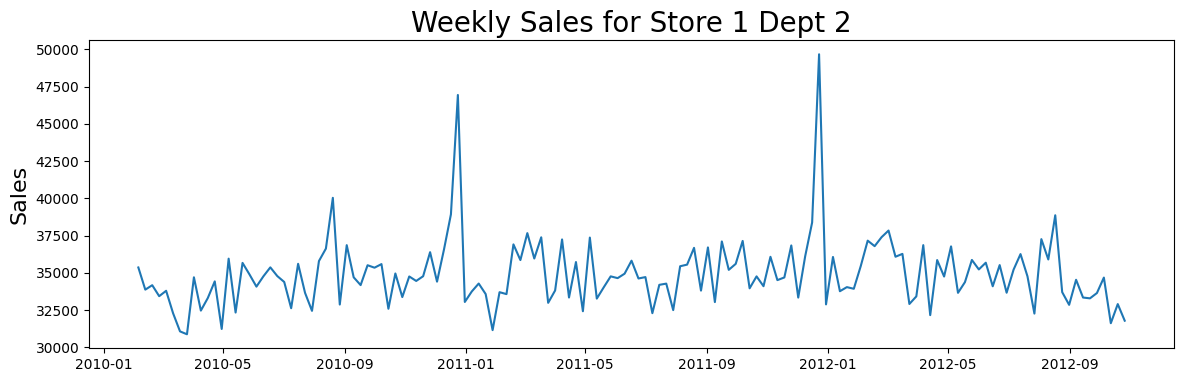

In [20]:
#plot
plt.figure(figsize=(14,4))
plt.plot(data2['Weekly_Sales'])
plt.title('Weekly Sales for Store 1 Dept 2', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

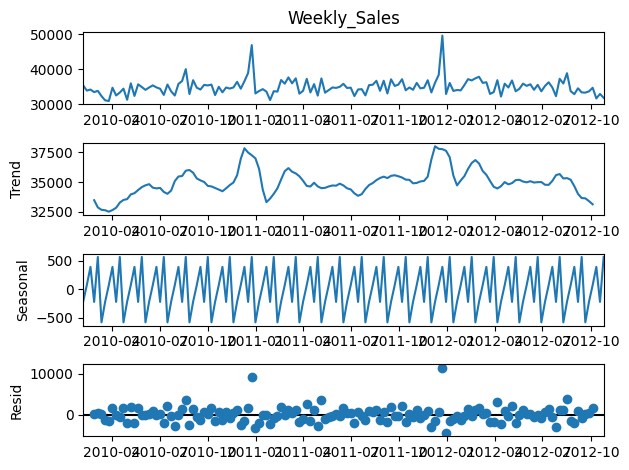

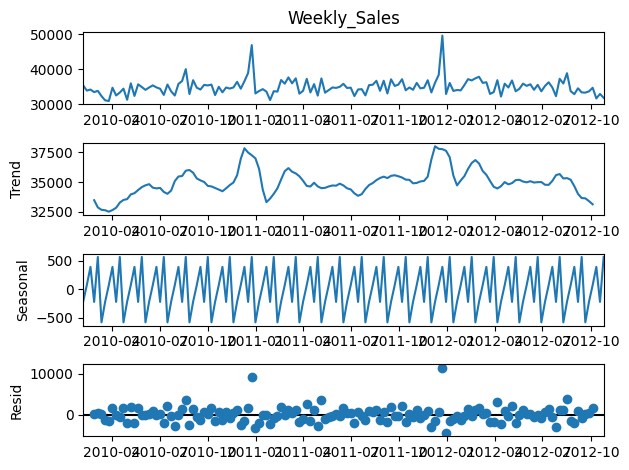

In [21]:
decomposition = seasonal_decompose(data2['Weekly_Sales'], model='additive', period=6)
decomposition.plot()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


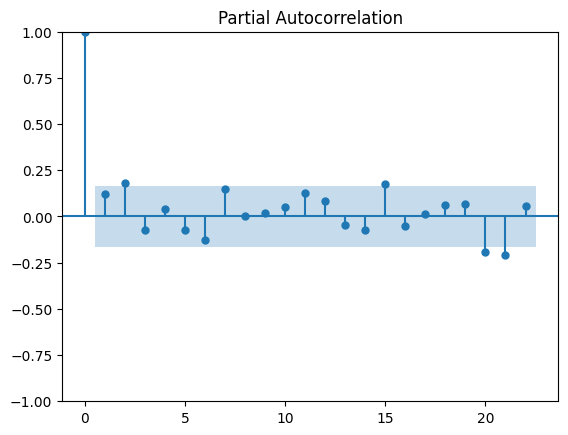

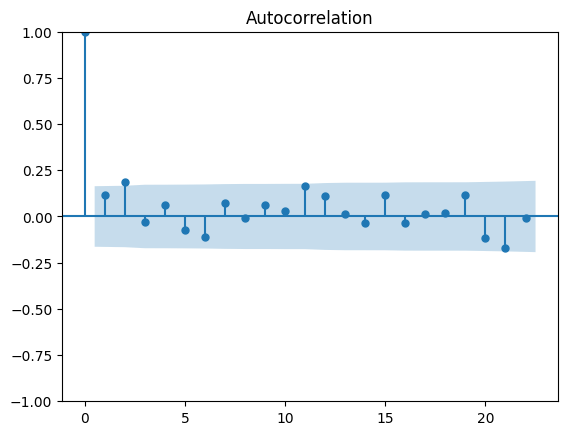

In [ ]:
#Applying sarima models to the data
plot_pacf(data2['Weekly_Sales']);
plot_acf(data2['Weekly_Sales']);

In [22]:
# To check data is stationary or not
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(data2['Weekly_Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.406266203244591
p-value: 1.9398538919332856e-08


In [23]:
# This time lets move on with the same data without having use of diff method as p is less than 0.05
# Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit p(AR)= 2
# Using the ACF here we can see that only 1 of the lag are out of the significance limit so we can say that the optimal value of our q (MA) is 1.
# d=1 as we have taken difference 1 time
# So order(p,d,q)
# for P,D,Q and s, P=1, D=1, Q=2 and s=52
result = SARIMAX(data2['Weekly_Sales'],order=(1,0,2), seasonal_order=(1,0,2,52))
result = result.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood               -1282.451
Date:                            Mon, 24 Jul 2023   AIC                           2578.901
Time:                                    16:29:20   BIC                           2599.641
Sample:                                02-05-2010   HQIC                          2587.329
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.43e-05   4.12e+04      0.000       1.000       1.000
ma.L1         -0.8312      0.074    -11.266      0.000      -0.976      -0.687
ma.L2          0.0024      0.083      0.029      0.977      -0.161       0.165
ar.S.L52       0.7616      0.134      5.680      0.000       0.499       1.024
ma.S.L52      -0.2122      0.250     -0.849      0.396      -0.702       0.278
ma.S.L104      0.4810      0.227      2.118      0.034       0.036       0.926
sigma2      1.942e+06   2.72e-07   7.13e+12      0.000    1.94e+06    1.94e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.53
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.92
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+29. Standard errors may be unstable.
"""

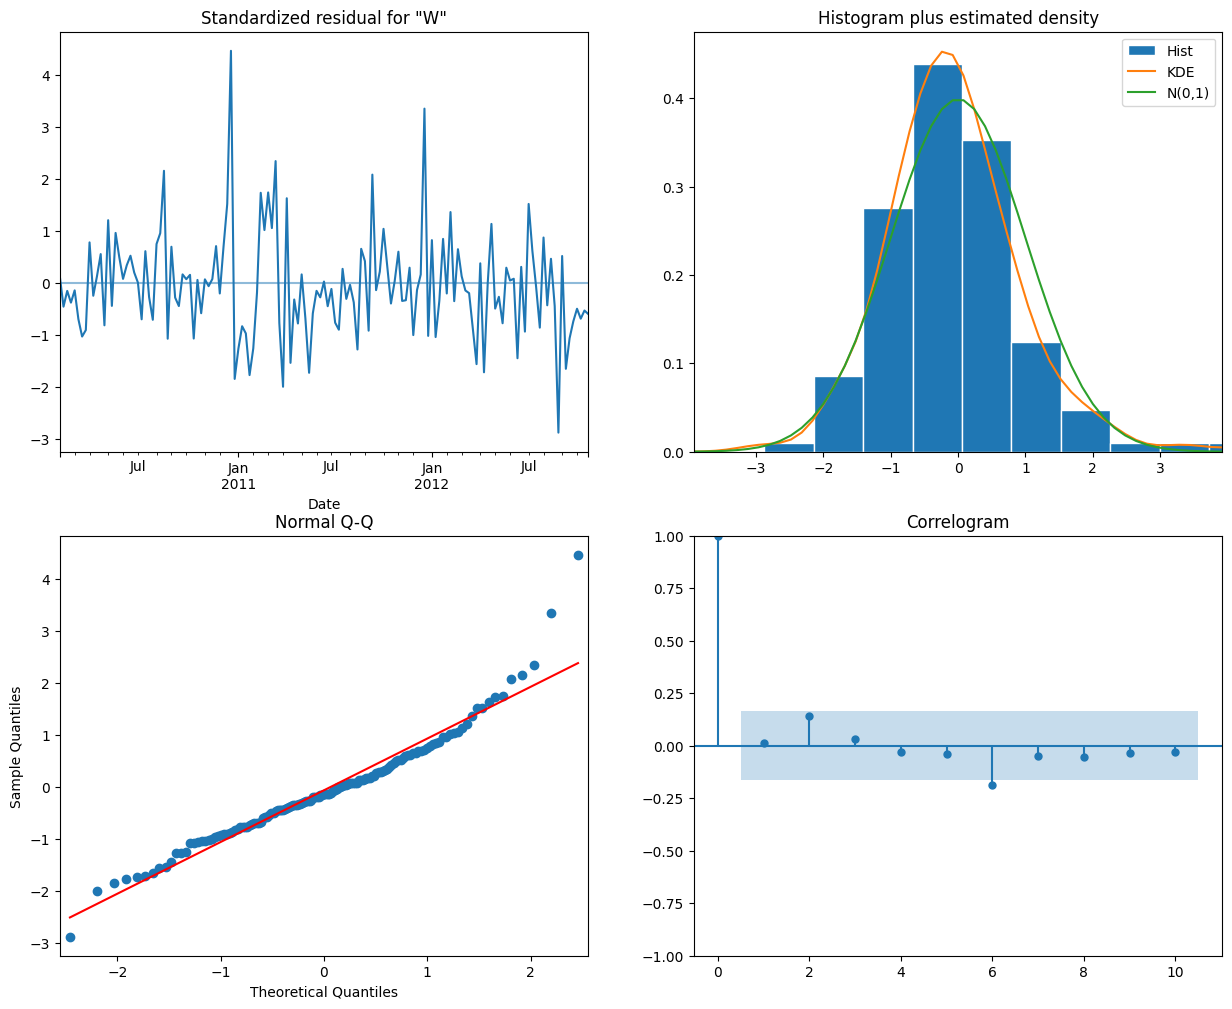

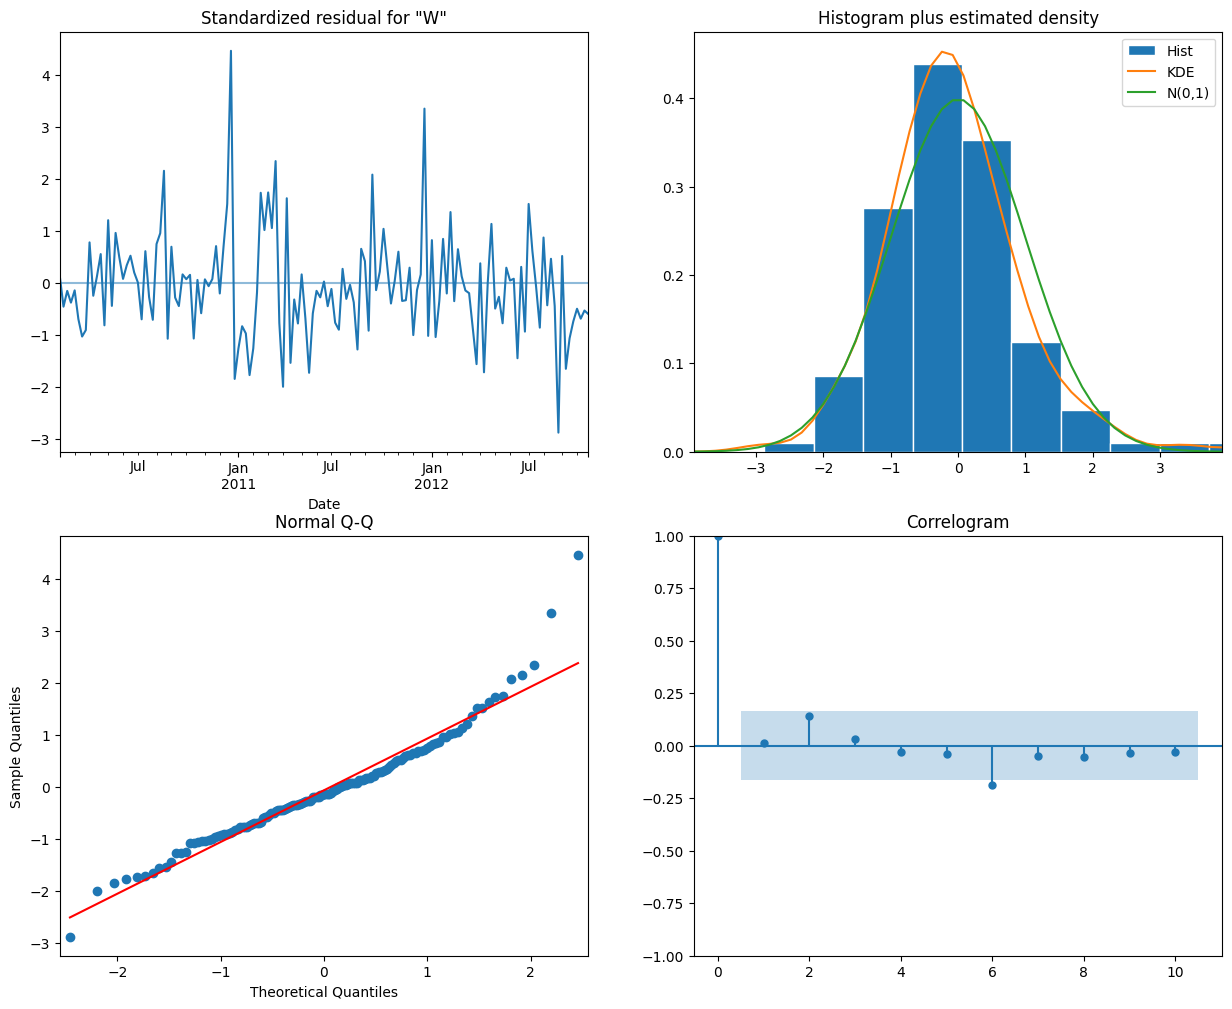

In [25]:

# Diagnosing the model residuals
result.plot_diagnostics(figsize=(15,12))
# From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality.
# The correlogram on the bottom right suggests that there is no autocorrelation in the residuals and so they are effectively white noise.
# Therefore, these residuals are uncorrelated and the mean is close to zero.

<ipython-input-40-b14aeac19410>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast = data2['sarima_model'].append(forecast)


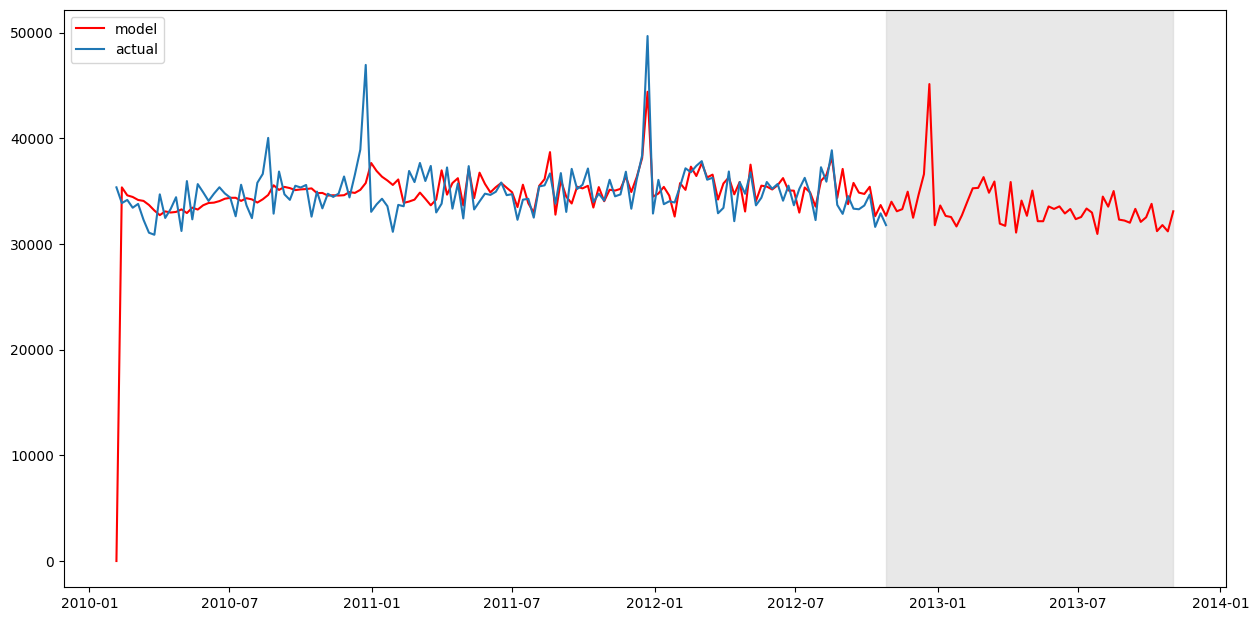

In [40]:
data2['sarima_model'] = result.fittedvalues
data2['sarima_model'].dropna()
forecast = result.predict(start=data2.shape[0], end=data2.shape[0] + 52)
forecast = data2['sarima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data2.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data2['Weekly_Sales'], label='actual')
plt.legend()
plt.show()

In [28]:
data2['sarima_model'].head()

Date
2010-02-05        0.000000
2010-02-12    35357.238341
2010-02-19    34603.192802
2010-02-26    34449.031978
2010-03-05    34166.547432
Freq: W-FRI, Name: sarima_model, dtype: float64

In [41]:
from sklearn.metrics import r2_score
data2 = data2.dropna(subset=['Weekly_Sales', 'sarima_model'])
observed_y = np.array(data2['Weekly_Sales'])

predicted_y = np.array(data2['sarima_model'])

r2 = r2_score(observed_y, predicted_y)

print("R-squared value:", r2)

R-squared value: -1.284958506145558
